# [모듈 2.1] SK Learn Ridge, Lasso Regresson 모델 훈련 및 평가

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import time
import json
import sagemaker.amazon.common as smac
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer

---
## Data

Let's download the data.  More information about this dataset can be found [here](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html).

In [2]:
# !wget http://robjhyndman.com/data/gasoline.csv

And take a look at it.

,thousands_barrels
0,6621.0
1,6433.0
2,6582.0
3,7224.0
4,6875.0


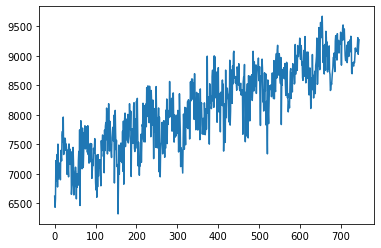

In [3]:
raw_gas = pd.read_csv('gasoline.csv', header=None, names=['thousands_barrels'])
display(raw_gas.head())
plt.plot(raw_gas)
plt.show()

As we can see, there's a definitive upward trend, some yearly seasonality, but sufficient volatility to make the problem non-trivial.  There are several unexpected dips and years with more or less pronounced seasonality.  These same characteristics are common in many topline time-series.

Next we'll transform the dataset to make it look a bit more like a standard prediction model.  Our target variable is `thousands_barrels`.  Let's create explanatory features, like:
- `thousands_barrels` for each of the 4 preceeding weeks.
- Trend.  The chart above suggests the trend is simply linear, but we'll create log and quadratic trends in case.
- Indicator variables {0 or 1} that will help capture seasonality and key holiday weeks.

## 피쳐 엔지니어링

In [4]:
def make_feature_engineering(gas):
    gas['thousands_barrels_lag1'] = gas['thousands_barrels'].shift(1)
    gas['thousands_barrels_lag2'] = gas['thousands_barrels'].shift(2)
    gas['thousands_barrels_lag3'] = gas['thousands_barrels'].shift(3)
    gas['thousands_barrels_lag4'] = gas['thousands_barrels'].shift(4)
    gas['trend'] = np.arange(len(gas))
    gas['log_trend'] = np.log1p(np.arange(len(gas)))
    gas['sq_trend'] = np.arange(len(gas)) ** 2
    weeks = pd.get_dummies(np.array(list(range(52)) * 15)[:len(gas)], prefix='week')
    gas = pd.concat([gas, weeks], axis=1)
    
    return gas

gas = make_feature_engineering(raw_gas)

Now, we'll:
- Clear out the first four rows where we don't have lagged information.
- Split the target off from the explanatory features.
- Split the data into training, validation, and test groups so that we can tune our model and then evaluate its accuracy on data it hasn't seen yet.  Since this is time-series data, we'll use the first 60% for training, the second 20% for validation, and the final 20% for final test evaluation.

In [5]:
print("gas :",gas.shape)
print(gas.columns)
gas

gas : (745, 60)
Index(['thousands_barrels', 'thousands_barrels_lag1', 'thousands_barrels_lag2',
       'thousands_barrels_lag3', 'thousands_barrels_lag4', 'trend',
       'log_trend', 'sq_trend', 'week_0', 'week_1', 'week_2', 'week_3',
       'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'week_9', 'week_10',
       'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16',
       'week_17', 'week_18', 'week_19', 'week_20', 'week_21', 'week_22',
       'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28',
       'week_29', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34',
       'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_40',
       'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46',
       'week_47', 'week_48', 'week_49', 'week_50', 'week_51'],
      dtype='object')


,thousands_barrels,thousands_barrels_lag1,thousands_barrels_lag2,thousands_barrels_lag3,thousands_barrels_lag4,trend,log_trend,sq_trend,week_0,week_1,...,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51
0,6621.0,NaN,NaN,NaN,NaN,0,0.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,6433.0,6621.0,NaN,NaN,NaN,1,0.693147,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,6582.0,6433.0,6621.0,NaN,NaN,2,1.098612,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7224.0,6582.0,6433.0,6621.0,NaN,3,1.386294,9,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6875.0,7224.0,6582.0,6433.0,6621.0,4,1.609438,16,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,9170.0,9089.0,9095.0,9075.0,9069.0,740,6.608001,547600,0,0,...,0,0,0,0,0,0,0,0,0,0
741,9306.0,9170.0,9089.0,9095.0,9075.0,741,6.609349,549081,0,0,...,0,0,0,0,0,0,0,0,0,0
742,9024.0,9306.0,9170.0,9089.0,9095.0,742,6.610696,550564,0,0,...,0,0,0,0,0,0,0,0,0,0
743,9175.0,9024.0,9306.0,9170.0,9089.0,743,6.612041,552049,0,0,...,0,0,0,0,0,0,0,0,0,0


## 훈련, 검증, 테스트 데이터 세트로 분리

Now, we'll convert the datasets to the recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms and upload this data to S3.  We'll start with training data.

In [6]:

train_border=0.6
test_border=0.8
n_lags = 4 ; label = 'thousands_barrels'   
gas = gas.iloc[n_lags:, ]
split_train = int(len(gas) * train_border)
split_test = int(len(gas) * test_border)

train_y = gas[label][:split_train]
train_X = gas.drop(label, axis=1).iloc[:split_train, ].to_numpy()
validation_y = gas[label][split_train:split_test]
validation_X = gas.drop(label, axis=1).iloc[split_train:split_test, ].to_numpy()
test_y = gas[label][split_test:]
test_X = gas.drop(label, axis=1).iloc[split_test:, ].to_numpy()


In [7]:
print(train_X.shape)
print(train_y.shape)


(444, 59)
(444,)


## 모델 훈련, 저장, 로딩

In [8]:
import joblib
import os

from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.model_selection import cross_val_score

def train(train_X, train_y, model):
    if model =='ridge':
        model = Ridge(alpha=3.0)
        print("Train Ridge model")
    elif model == 'lasso':
        model = Lasso(alpha=3.0)
        print("Train Lasso model")        
        
    model.fit(train_X, train_y)        
    
    return model



def save_model(model, model_folder, model_name):
    save_path = os.path.join(model_folder, model_name)
    joblib.dump(model, save_path)
    print(f'{save_path} is saved')
    
def model_fn(model_dir):
    """
    Deserialized and return fitted model
    Note that this should have the same name as the serialized model in the main method
    """   
    pca = joblib.load(os.path.join(model_dir, "model.joblib"))
    
    return pca

def predict_fn(input_data, model):
    """Preprocess input data
    """
    payload = input_data
    
    predictions = model.predict(payload)
    print("shape of predictions: ", predictions.shape)

    return predictions

def input_fn(input_data, request_content_type='text/csv'):
    """
    """
    n_feature = input_data.shape[1]
    sample = input_data.reshape(-1,n_feature)
    return sample

def evaluate(test_y, pred, metric = 'MdAPE'):
    '''
    # Naive MdAPE = 0.03687277085962615
    # One-step-ahead MdAPE =  0.020360223119258346    
    '''
    if metric == 'MdAPE':
        MdAPE = np.median(np.abs(test_y - pred) / test_y)    
    return MdAPE


In [9]:
# Train
model_ridge = train(train_X, train_y, model = 'ridge')
# model_lasso = train(train_X, train_y, model = 'lasso')

# Save Model
model_folder = 'model'    
os.makedirs(model_folder, exist_ok=True)
model_name = 'model.joblib'
save_model(model_ridge, model_folder, model_name)

# input for evaluation
sample = input_fn(test_X)

# Load model
model_ridge = model_fn(model_folder)



Train Ridge model
model/model.joblib is saved


## 모델 평가

In [10]:
def compute_naive_pred(gas, split_test):
    gas_eval = gas.copy()
    gas_eval['thousands_barrels_lag52'] = gas['thousands_barrels'].shift(52)
    gas_eval['thousands_barrels_lag104'] = gas['thousands_barrels'].shift(104)
    gas_eval['thousands_barrels_naive_forecast'] = gas_eval['thousands_barrels_lag52'] ** 2 / gas_eval['thousands_barrels_lag104']
    naive = gas_eval[split_test:]['thousands_barrels_naive_forecast'].to_numpy()
    
    return naive

naive = compute_naive_pred(gas, split_test)

In [11]:
print(test_y.shape)

print(naive.shape)

(149,)
(149,)


Naive-onestep-ahead MdAPE =  0.03687277085962615


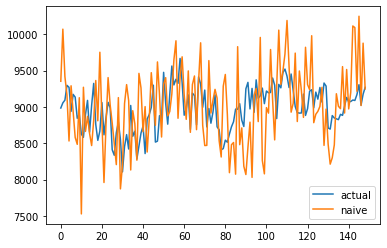

In [12]:

def show_chart(test_y, pred):
    plt.plot(np.array(test_y), label='actual')
    plt.plot(pred, label='naive')
    plt.legend()
    plt.show()

MdAPE = evaluate(test_y, naive)
print('Naive-onestep-ahead MdAPE = ', MdAPE)    
show_chart(test_y, naive) 

shape of predictions:  (149,)
Ridge-onestep-ahead MdAPE =  0.021790265344816973


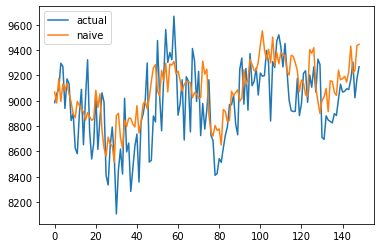

In [13]:
# Predict
ridge_pred = predict_fn(sample, model_ridge)
# lasso_pred = predict_fn(model_lasso, sample)

# Evaluate
MdAPE = evaluate(test_y, ridge_pred)
print('Ridge-onestep-ahead MdAPE = ', MdAPE)

show_chart(test_y, ridge_pred) 